In [1]:
# To solve this task, we will use the concept of Topic Modeling (LDA) on Amazon Automotive Review data

In [2]:
# Let’s first load all the necessary libraries:

In [56]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re

In [15]:
import gensim
from gensim import corpora

In [55]:
import spacy # Spacy Installation Command: conda install -c conda-forge spacy

In [23]:
# libraries for visualization
import pyLDAvis # pip install pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
# Inport Dataset 
# To import the data, first extract the data to your working directory and then use the read_json( ) function 
# of pandas to read it into a pandas dataframe
df = pd.read_json('Automotive_5.json', lines=True)

In [26]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,"Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...","07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,"I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...","12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,"I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...","07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [27]:
# reviewerID – ID of the reviewer
# asin – ID of the product
# reviewerName – name of the reviewer
# helpful – helpfulness rating of the review, e.g. 2/3
# reviewText – text of the review
# overall – rating of the product
# summary – summary of the review
# unixReviewTime – time of the review (unix time)
# reviewTime – time of the review (raw)

In [28]:
# For the scope of our analysis and this article, we will be using only the reviews column, i.e., reviewText.

In [29]:
# DATA PRE-PROCESSING

In [37]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

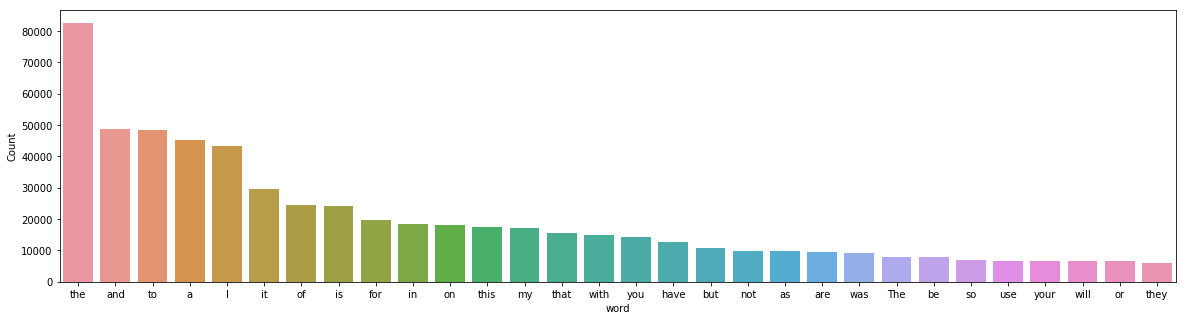

In [38]:
freq_words(df['reviewText'])

In [39]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [40]:
# Let’s try to remove the stopwords and short words (<2 letters) from the reviews.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [41]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new


In [42]:
# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

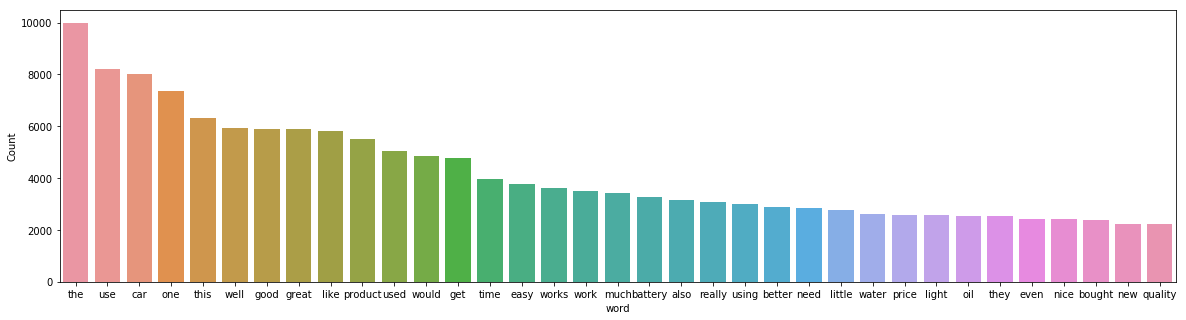

In [43]:
# Let’s again plot the most frequent words and see if the more significant words have come out.
freq_words(reviews, 35)

In [44]:
# To further remove noise from the text we can use lemmatization from the spaCy library. 
# It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [104]:
nlp = spacy.load('en', disable=['parser', 'ner'])   # Run this command as ADMIN: python -m spacy download en

In [93]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [94]:
# Let’s tokenize the reviews and then lemmatize the tokenized reviews

In [95]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


29

In [96]:
#from spacy.lemmatizer import Lemmatizer
#from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
#lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

In [105]:
reviews_2 = lemmatization(tokenized_reviews)

In [106]:
print(reviews_2[1])
len(reviews_2[1])

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


17

In [107]:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'bucks',
 'cables',
 'expecting',
 'for',
 'knock',
 'like',
 'see',
 'seem',
 'seems',
 'snap',
 'these',
 'work',
 'would'}

In [108]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

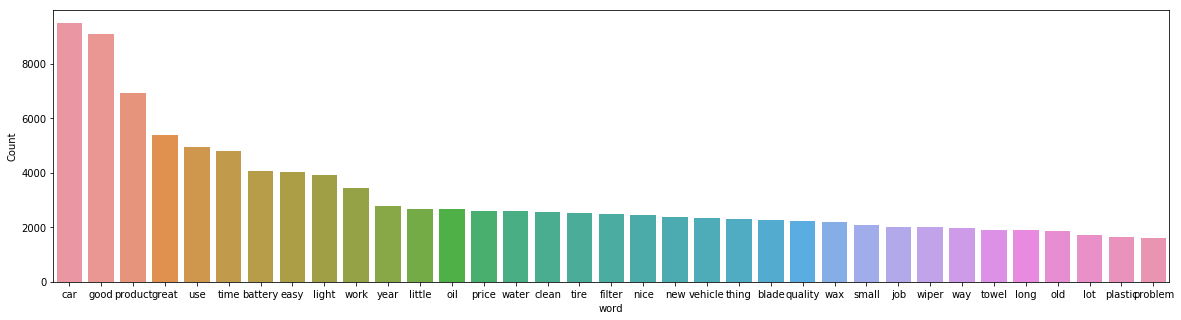

In [109]:
# As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. 
# Let’s de-tokenize the lemmatized reviews and plot the most common words.
freq_words(df['reviews'], 35)

In [110]:
# It seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.

In [111]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [113]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [114]:
doc_term_matrix

[[(0, 1),
  (1, 2),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 1),
  (23, 1)],
 [(10, 1),
  (12, 1),
  (13, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1)],
 [(2, 1),
  (10, 1),
  (11, 1),
  (13, 1),
  (15, 1),
  (18, 1),
  (21, 1),
  (25, 4),
  (31, 1),
  (36, 3),
  (37, 1),
  (38, 1),
  (39, 4),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 2),
  (66, 2),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 3),
  (76, 2),
  (77, 1),
  (78, 1

In [115]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [116]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [117]:
# Let’s print out the topics that our LDA model has learned
lda_model.print_topics()

[(0,
  '0.021*"oil" + 0.019*"good" + 0.015*"filter" + 0.014*"car" + 0.012*"product" + 0.010*"engine" + 0.010*"price" + 0.010*"water" + 0.010*"change" + 0.009*"tank"'),
 (1,
  '0.059*"tire" + 0.048*"leather" + 0.033*"wheel" + 0.020*"gauge" + 0.018*"seat" + 0.018*"brush" + 0.017*"mat" + 0.017*"pressure" + 0.012*"clean" + 0.011*"brake"'),
 (2,
  '0.045*"car" + 0.034*"product" + 0.024*"towel" + 0.023*"good" + 0.016*"wax" + 0.015*"clean" + 0.014*"water" + 0.014*"use" + 0.013*"great" + 0.012*"time"'),
 (3,
  '0.046*"blade" + 0.038*"wiper" + 0.017*"windshield" + 0.015*"good" + 0.013*"car" + 0.013*"rain" + 0.010*"snow" + 0.010*"year" + 0.010*"window" + 0.009*"side"'),
 (4,
  '0.014*"good" + 0.013*"easy" + 0.011*"use" + 0.011*"great" + 0.011*"hose" + 0.010*"small" + 0.009*"work" + 0.009*"little" + 0.009*"plastic" + 0.009*"thing"'),
 (5,
  '0.067*"light" + 0.031*"bulb" + 0.021*"bright" + 0.014*"good" + 0.014*"white" + 0.011*"color" + 0.011*"headlight" + 0.011*"great" + 0.008*"kit" + 0.008*"jeep"

In [119]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\Owner\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.074757  0.030130       1        1  21.571367
2      0.043308 -0.085823       2        1  21.187977
0      0.055640 -0.096910       3        1  16.991112
6      0.059420 -0.178745       4        1  14.623308
5      0.079351  0.236417       5        1   9.826531
3      0.073310  0.076980       6        1   9.574568
1     -0.385785  0.017953       7        1   6.225141, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
148    Default  4548.000000        light  4548.000000  30.0000  30.0000
39     Default  2953.000000      battery  2953.000000  29.0000  29.0000
955    Default  2412.000000        blade  2412.000000  28.0000  28.0000
337    Default  1997.000000         tire  1997.000000  27.0000  27.0000
2      Default  9430.000000          car  9430.000000  26.0000  26.0000
931    Default  2010.000000        wiper  2010.000000  25.0000  25.0000
1319   Default  1622.000000      leather  1622.000000  24.0000  24.0000
530    Default  2804.000000        towel  2804.000000  23.0000  23.0000
2586   Default  1643.000000         bulb  1643.000000  22.0000  22.0000
169    Default  1927.000000          oil  1927.000000  21.0000  21.0000
722    Default  1124.000000        wheel  1124.000000  20.0000  20.0000
526    Default  1851.000000          wax  1851.000000  19.0000  19.0000
320    Default  6440.000000      product  6440.000000  18.0000  18.0000
62     Default  1531.000000        power  1531.000000  17.0000  17.0000
1275   Default  1114.000000       bright  1114.000000  16.0000  16.0000
966    Default  1422.000000       filter  1422.000000  15.0000  15.0000
95     Default  2406.000000        clean  2406.000000  14.0000  14.0000
760    Default  1139.000000       device  1139.000000  13.0000  13.0000
930    Default   866.000000   windshield   866.000000  12.0000  12.0000
551    Default  1265.000000         wash  1265.000000  11.0000  11.0000
733    Default  1147.000000         unit  1147.000000  10.0000  10.0000
235    Default   806.000000         seat   806.000000   9.0000   9.0000
51     Default   700.000000        gauge   700.000000   8.0000   8.0000
646    Default  1179.000000        paint  1179.000000   7.0000   7.0000
525    Default  2847.000000        water  2847.000000   6.0000   6.0000
1103   Default   941.000000     pressure   941.000000   5.0000   5.0000
604    Default   906.000000        white   906.000000   4.0000   4.0000
510    Default  1136.000000          air  1136.000000   3.0000   3.0000
728    Default  1525.000000         hose  1525.000000   2.0000   2.0000
512    Default   613.000000        brush   613.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
2291    Topic7    80.630249      fixture    81.348289   2.7677  -6.0441
15853   Topic7    79.906067      bissell    80.625320   2.7676  -6.0531
2197    Topic7    72.737473       backup    73.451149   2.7668  -6.1471
2759    Topic7    67.577637   upholstery    68.287521   2.7661  -6.2207
4488    Topic7    66.237206     sunglass    66.951256   2.7659  -6.2407
2877    Topic7    65.158852         food    65.872017   2.7657  -6.2572
1053    Topic7    63.446407  convenience    64.162407   2.7654  -6.2838
5778    Topic7    61.987869         mask    62.703506   2.7651  -6.3070
4494    Topic7    63.254509        juice    63.986973   2.7651  -6.2868
51      Topic7   678.531433        gauge   700.697998   2.7444  -3.9141
473     Topic7   378.723236        board   429.065552   2.6518  -4.4972
1733    Topic7   158.712906    impressed   176.358551   2.6712  -5.3669
235     Topic7   617.151306         seat   806.676697   2.5088  -4.0089
1544    Topic7   390.747681        brake   495.591980   2.5389  -4.4659
1980    Topic7   122.042404         face   134.174561   2.6818  -5.6296
1406    Topic7 